- Character-Level RNN은 word를 character의 sequence로 읽어들임
- 각 단계의 예측과 hidden state를 출력하고, 다음 단계에 이전 은닉 상태를 전달
- 18개의 언어로 된 수천 개의 성(surname)을 훈련시키고, 철자에 따라 이름이 어떤 언어인지 예측
- 데이터 다운: https://download.pytorch.org/tutorial/data.zip

**Preparing the Data**

In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print('- find files:', findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;"
print(all_letters)

# 유니코드 문자열 → ASCII 변환
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

print('- unicode to ascii:', unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일 읽고 줄 단위로 분리
def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)
print('ex) Italian Surnames:', category_lines['Italian'][:5])

- find files: ['data/names/Dutch.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/French.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Spanish.txt', 'data/names/Czech.txt', 'data/names/Portuguese.txt']
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;
- unicode to ascii: Slusarski
ex) Italian Surnames: ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


**Turning Names into Tensors**
- 모든 이름을 체계화 했으므로 이를 활용하기 위해 Tensor로 변환
- 하나의 문자를 표현하기 위해, 크기가 `<1 x n_letters>` 인 one-hot vector 사용
- One-hot vector example: b = `<0 1 0 0 0 ... >`
- 단어를 만들기 위해 one-hot vector들을 2차원 행렬 `<line_length x 1 x n_letters>` 에 결합시킴 (1 = batch 크기)

In [9]:
import torch

# all_letters로 문자 주소 찾기 (ex. a = 0)
def letterToIndex(letter):
  return all_letters.find(letter)

# 하나의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

# 한 줄(이름)을 <line_length x 1 x n_letters> 로 변경
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print("- letter 'J' to tensor:", letterToTensor('J'))
print("- name 'Jones' to tensor:", lineToTensor('Jones').size())

- letter 'J' to tensor: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
- name 'Jones' to tensor: torch.Size([5, 1, 56])


**Creating Network**
- RNN 모듈은 입력 및 은닉 상태로 작동하는 2개의 선형 계층이며, 출력 다음에 LogSoftmax 계층이 있음
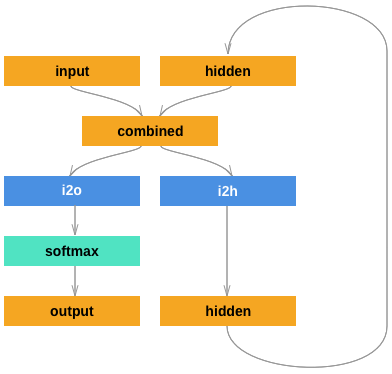

In [10]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)
  
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

- 이 네트워크의 한 단계를 실행하려면 input(현재의 문자 Tensor)과 이전의 hidden state(맨 처음은 0으로 초기화)을 전달해야 함
- Output(각 언어의 확률)과 다음 hidden state(다음 단계를 위해 유지)를 돌려받음

In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

- 효율을 위해 매 단계마다 새 Tensor를 만들지 않고, `letterToTensor` 대신 `lineToTensor`를 잘라 사용

In [12]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7700, -2.9557, -2.8447, -2.9383, -2.8801, -2.9594, -2.9237, -2.9557,
         -2.8913, -2.9128, -2.8235, -2.9477, -2.9313, -2.8542, -2.8515, -2.7844,
         -2.9038, -2.9286]], grad_fn=<LogSoftmaxBackward0>)


**Preparing for Training**
- 네트워크의 출력으로, 가장 확률이 높은 카테고리 이름(언어)과 카테고리 번호 반환

In [14]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1) # tensor의 가장 큰 값 및 주소
  category_i = top_i[0].item() # tensor에서 정수 값으로 변환
  return all_categories[category_i], category_i

print('- guess based on the output:', categoryFromOutput(output))

- guess based on the output: ('Dutch', 0)


In [15]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, '/ line =', line)

category = Dutch / line = Bueren
category = Dutch / line = Marquering
category = Korean / line = Koo
category = Dutch / line = Romeijn
category = German / line = Koenig
category = Russian / line = Awtaeff
category = Czech / line = Skwor
category = Czech / line = Piskach
category = Irish / line = Coilean
category = Chinese / line = Mah


**Training the Network**
- RNN의 마지막 계층이 `nn.LogSoftmax` 이므로 loss function으로 `nn.NLLLoss`가 적합함

In [16]:
criterion = nn.NLLLoss()

- Training loop:
  1. input과 target tensors 생성
  2. zeroed initial hidden state 생성
  3. forward pass: 각 문자 읽고 다음 문자를 위해 hidden state 유지
  4. target과 최종 output 비교
  5. backward pass: backprop
  6. output과 loss 출력

In [19]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad() # initalize

  # 들어온 이름에 대해 forward pass 진행
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  
  # backward pass 진행
  loss = criterion(output, category_tensor)
  loss.backward()

  # optimization: gradient descent
  # 매개변수의 gradient에 learning rate를 곱해서 그 매개변수의 값에 더함
  # RNN은 각 스텝마다 같은 매개변수 W, b를 사용하기 때문에 backprop이 진행되며 모든 스텝에 걸쳐 매개변수의 값이 합산됨
  # 이렇게 update 된 가중치는 forward pass 동안에는 모든 스텝에 동일한 가중치로 적용됨
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)
  
  return output, loss.item()

- 예시 데이터 사용하여 실행

In [20]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 도식화를 위한 loss 추적
current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample() # train data random select
  output, loss = train(category_tensor, line_tensor) # RNN
  current_loss += loss

  # iter 숫자, loss, 이름, 추측 화면 출력
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

  # 현재 평균 loss을 전체 loss 리스트에 추가
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 4s) 0.2791 Stavropoulos / Greek ✓
10000 10% (0m 9s) 2.5282 Fleming / German ✗ (Scottish)
15000 15% (0m 14s) 0.0568 Haritopoulos / Greek ✓
20000 20% (0m 19s) 4.3629 Fabian / Irish ✗ (Polish)
25000 25% (0m 24s) 1.4486 Belikin / Russian ✓
30000 30% (0m 28s) 4.8731 Fabian / Irish ✗ (Polish)
35000 35% (0m 33s) 0.0551 Sniegowski / Polish ✓
40000 40% (0m 39s) 2.3179 Suero / Portuguese ✗ (Spanish)
45000 45% (0m 44s) 2.7623 Shaw / Chinese ✗ (Scottish)
50000 50% (0m 49s) 0.4409 Iwasa / Japanese ✓
55000 55% (0m 53s) 0.6402 Kaibara / Japanese ✓
60000 60% (0m 58s) 1.6552 Polites / Portuguese ✗ (Greek)
65000 65% (1m 3s) 1.2110 Ybarra / Spanish ✓
70000 70% (1m 8s) 2.2455 Santana / Spanish ✗ (Portuguese)
75000 75% (1m 13s) 0.6338 Jong / Korean ✓
80000 80% (1m 21s) 0.5150 Chew / Chinese ✓
85000 85% (1m 25s) 0.0653 Ryjenkov / Russian ✓
90000 90% (1m 30s) 1.3464 Accardo / Portuguese ✗ (Italian)
95000 95% (1m 35s) 4.2124 Gaudin / Irish ✗ (English)
100000 100% (1m 40s) 0.2265 Ly / Vietnamese ✓


**Plotting the Results**

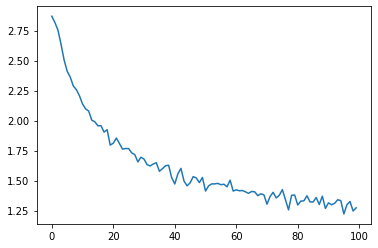

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

**Evaluating the Results**
- 네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해 모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지 나타내는 confusion matrix 생성

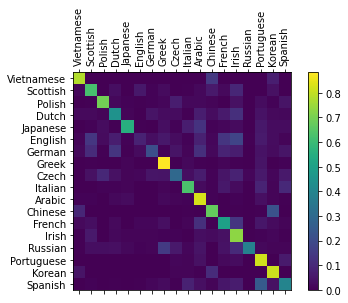

In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  
  return output

# 예시들 중 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

**Running on User Input**

In [ ]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    # get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.92) Czech
(-1.00) Russian
(-2.65) English

> Jackson
(-0.36) Scottish
(-2.14) Greek
(-2.30) English

> Satoshi
(-1.12) Japanese
(-1.26) Arabic
(-1.39) Italian
